In [1]:
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn.functional as F

import matplotlib.pyplot as plt



image_size = 512  # the generated image resolution
train_batch_size = 4
eval_batch_size = 4  # how many images to sample during evaluation
num_epochs = 50
gradient_accumulation_steps = 1
learning_rate = 1e-4
lr_warmup_steps = 500
save_image_epochs = 10
save_model_epochs = 30
mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
output_dir = "corn-rows"  # the model name locally and on the HF Hub
data_dir = "/home/ubuntu/diffusion-tutorial/data"
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
seed = 0


/home/ubuntu/.cache/pypoetry/virtualenvs/diffusion-0Ckba9k--py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Create transformation concatenation with random horizontal and vertical flips
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.CenterCrop(460),
    torchvision.transforms.Resize(image_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

class SimpleImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'jpeg', 'png', 'JPG', 'JPEG', 'PNG'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        return {"image": image}


# Load the dataset
dataset = SimpleImageDataset(data_dir, transform=transform)

# Custom collate function for DataLoader
def collate_fn(batch):
    images = [item['image'] for item in batch]
    images = torch.stack([torch.tensor(image).permute(2, 1, 0) for image in images])  # Convert to (C, H, W) format
    return images

train_dataloader = DataLoader(
    dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn,
)

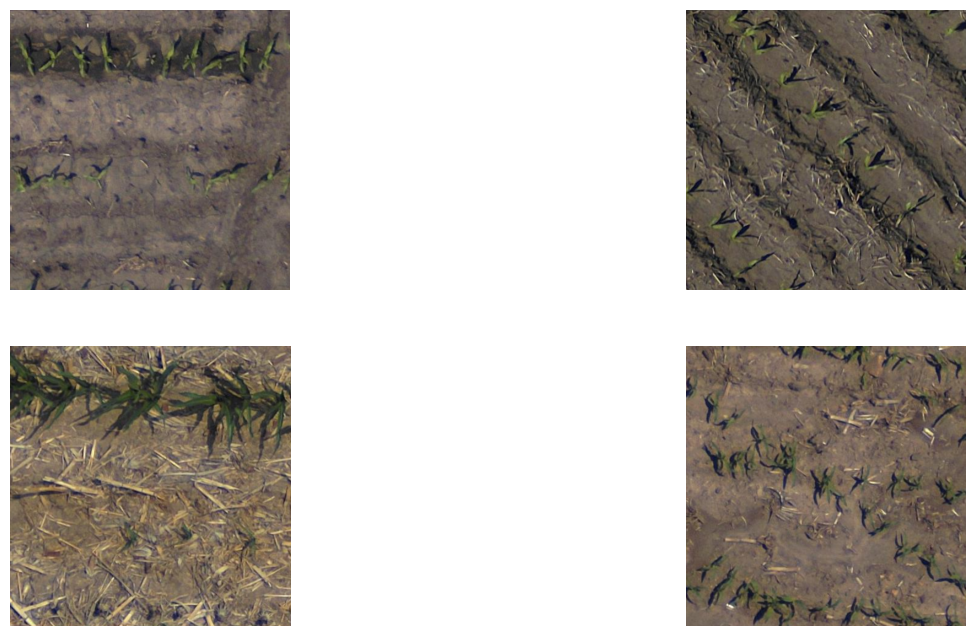

In [30]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Visualize the dataset
plt.figure(figsize=(16, 8))
for i in range(4):
    image = dataset[i]["image"]
    image = denormalize(image, mean, std)
    plt.subplot(2, 2, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")
plt.show()

# for step, batch in enumerate(train_dataloader):
#     fig, axs = plt.subplots(4, 1, figsize=(16, 4))
#     for i, image in enumerate(batch):
#         axs[i].imshow(image)
#         axs[i].set_axis_off()
#     fig.show()

In [7]:
import numpy as np
from torchvision import datasets

# Calculate mean and std for the dataset
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

mean = 0.
std = 0.
nb_samples = 0.

for step, batch in enumerate(train_dataloader):
    data = batch[0]
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'Mean: {mean}')
print(f'Std: {std}')


/tmp/ipykernel_356185/2099039173.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.stack([torch.tensor(image).permute(2, 1, 0) for image in images])  # Convert to (C, H, W) format
/tmp/ipykernel_356185/2099039173.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.stack([torch.tensor(image).permute(2, 1, 0) for image in images])  # Convert to (C, H, W) format
/tmp/ipykernel_356185/2099039173.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.stack([torch.tensor(image).permute(2, 1, 0) for

Mean: tensor([-0.4239, -0.4241, -0.4233, -0.4232, -0.4231, -0.4224, -0.4225, -0.4243,
        -0.4236, -0.4231, -0.4241, -0.4252, -0.4259, -0.4255, -0.4239, -0.4232,
        -0.4236, -0.4235, -0.4254, -0.4262, -0.4258, -0.4267, -0.4273, -0.4262,
        -0.4268, -0.4273, -0.4258, -0.4249, -0.4249, -0.4248, -0.4246, -0.4252,
        -0.4258, -0.4257, -0.4251, -0.4252, -0.4264, -0.4272, -0.4260, -0.4254,
        -0.4258, -0.4257, -0.4253, -0.4266, -0.4271, -0.4265, -0.4266, -0.4270,
        -0.4260, -0.4258, -0.4289, -0.4272, -0.4266, -0.4267, -0.4266, -0.4265,
        -0.4270, -0.4281, -0.4276, -0.4260, -0.4261, -0.4260, -0.4253, -0.4243,
        -0.4237, -0.4238, -0.4243, -0.4248, -0.4249, -0.4262, -0.4243, -0.4245,
        -0.4246, -0.4241, -0.4244, -0.4255, -0.4253, -0.4236, -0.4253, -0.4248,
        -0.4252, -0.4252, -0.4256, -0.4259, -0.4258, -0.4254, -0.4258, -0.4271,
        -0.4263, -0.4261, -0.4255, -0.4242, -0.4240, -0.4246, -0.4248, -0.4244,
        -0.4245, -0.4261, -0.4258,

In [3]:
import torch
from diffusers import DDPMPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipeline = DDPMPipeline.from_pretrained('/home/ubuntu/diffusion-tutorial/corn-rows-255-normalized-512').to(device)

pipeline.scheduler.timesteps



Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]


tensor([999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986,
        985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972,
        971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958,
        957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944,
        943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930,
        929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916,
        915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902,
        901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888,
        887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874,
        873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860,
        859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846,
        845, 844, 843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832,
        831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 8

In [ ]:
image = pipeline().images[0]
image.save("ddpm_generated_image.png")